In [6]:
from os.path import join

In [7]:
DATA_ROOT="../datas/2_Domain_Adaptation_dataset/"

MRI_root_dir=join(DATA_ROOT,"MRI","MRI_Label")
MRI_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_Label/annotations.json")

CT_root_dir=join(DATA_ROOT,"CT")
CT_anno_file=join(DATA_ROOT,"CT","annotations/annotations.json")

In [67]:
import cv2
import numpy as np
from pydicom import dcmread
import torch
import torch.utils.data as tud
from pycocotools.coco import COCO
### Utils
def load_dcm(fname):
    ds=dcmread(fname).pixel_array
    # 調整格式以配合albumentation套件需求
    return ds.astype('uint8')
def load_msk(fname):
    msk = cv2.imread(fname)[...,0]
    # 調整格式以配合albumentation套件需求
    return msk.astype('uint8')
### Dataset
class CTMRI_MultiClassDataset(tud.Dataset):
    def __init__(self,anno_file,
                 root_dir,transform=None):
        
        self.root_dir=root_dir
        self.transform=transform
        self.coco_obj=COCO(anno_file)
        self.img_obj=self.coco_obj.imgs
        self.n_cats=len(self.coco_obj.cats)
        self.cat_ids=list(self.coco_obj.cats.keys())
    def __len__(self) -> int:
        return len(self.img_obj)
    def __getitem__(self,id):
        img_obj=self.img_obj[id]
        # Read dcm to image
        image = load_dcm(join(self.root_dir,img_obj['file_name']))
        # read mask
        mask = load_msk(join(self.root_dir,img_obj['mask_file']))
        # Albumentation
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image,mask = transformed['image'],transformed['mask']
        # Image preparation    
        image = image[np.newaxis,...].repeat(3,axis=0)
        # Mask preparation
        mapping=np.vectorize(lambda x: ([0]+self.cat_ids).index(x))
        mask=mapping(mask)
        return image,mask

In [80]:
import albumentations as A
WIDTH, HEIGHT=256,256
target_transform = A.Compose([
#   A.Normalize(p=1, mean=(0.485), std=(0.229)),
  A.ToFloat(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])
ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,transform=target_transform)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [82]:
from utils.plotting import show_image_annot
x,y=next(iter(tud.DataLoader(ds,batch_size=4,shuffle=True)))
show_image_annot(x.numpy().transpose(0,2,3,1),y.numpy())

{0, 1, 2, 3, 4, 5}

BATCHSIZE= 4
(4, 256, 256, 3) 
 (4, 256, 256)


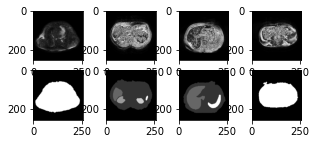